In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib as mpl

# mpl.rc('font', family='serif', serif='cmr10')
# plt.rcParams['axes.unicode_minus'] = False

# # Enable LaTeX rendering
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb} \usepackage{newtxtext, newtxmath}'

# # Ajustar el tamaño de fuente globalmente
# plt.rcParams.update({'font.size': 14})

In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = 'Gulliver.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Gulliver'
plt.rcParams['font.sans-serif'] = prop.get_name()
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 10,  # Tamanho de fonte recomendado para artigos científicos (8-12 pt)
    "axes.labelsize": 10,  # Tamanho dos rótulos dos eixos
    "axes.titlesize": 10,  # Tamanho do título
    "xtick.labelsize": 10,  # Tamanho dos ticks do eixo X
    "ytick.labelsize": 10,  # Tamanho dos ticks do eixo Y
    "legend.fontsize": 10,  # Tamanho da legenda
})

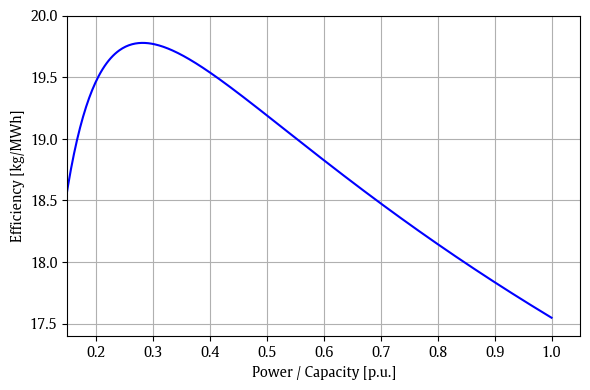

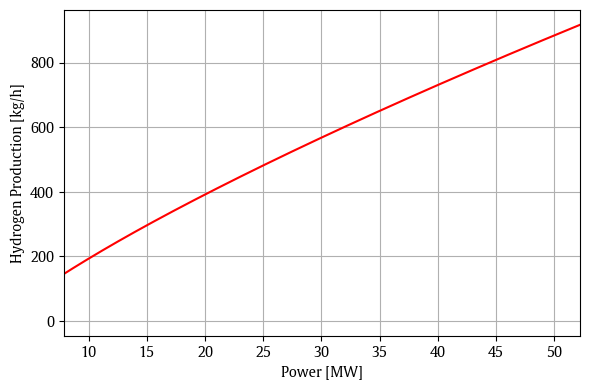

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.rc('font', family='serif', serif='cmr10', size=10)
#plt.rcParams['axes.unicode_minus'] = False

# Constants
a1, a2, a3, a4 = 1.5184, 1.5421E-03, 9.523E-05, 9.84E-08  # Reversible voltage coefficients
r1, r2 = 4.45153E-05, 6.88874E-09  # Ohmic resistance coefficients
d1, d2 = -3.12996E-06, 4.47137E-07  # Pressure dependency coefficients
s, t1, t2, t3 = 0.33824, -0.01539, 2.00181, 15.24178  # Activation overpotential parameters
f11, f12, f21, f22 = 478645.74, -2953.15, 1.0396, -0.00104  # Faraday efficiency parameters
F_const = 96485.3321  # Faraday constant in C/mol
M_H2 = 2.0159  # Molar mass of hydrogen (kg/kmol)
HHV = 39.41  # Higher Heating Value of Hydrogen (MWh/kg)
T_cell = 90  # Cell temperature in Celsius
p_cell = 30  # Cell pressure in bar
A_cell = 0.2  # Electrode area (m²)
C_E = 104.5 / 2  # Electrolyzer capacity (MW)
i_max = 5000  # Maximum current density (A/m²)

# Define range for Current Density (i)
i = np.linspace(1, i_max, 500)  # Avoid zero to prevent log issues

# Functions
def U_rev(T):
    """Computes reversible cell voltage."""
    T_K = T + 273.15
    return a1 - a2 * T_K + a3 * T_K * np.log(T_K) + a4 * T_K**2

def U_cell(T, p, i):
    """Computes real cell voltage."""
    return U_rev(T) + ((r1 + d1) + r2 * T + d2 * p) * i + s * np.log10((t1 + t2 / T + t3 / T**2) * i + 1)

def P_cell(T, p, i):
    """Computes cell power consumption."""
    return i * U_cell(T, p, i)

def eta_F(T, i):
    """Computes Faraday efficiency."""
    return (i**2 / (f11 + f12 * T + i**2)) * (f21 + f22 * T)

def H2_production(T, i, A, n_c):
    """Computes hydrogen production rate (kg/h)."""
    return (eta_F(T, i) * n_c * M_H2 * i * A) / (2 * F_const) * 3.6  # Convert from kg/s to kg/h

def eta_kg_per_MWh(T, i, A, n_c):
    """Computes efficiency in kg/MWh."""
    P_elec = P_cell(T, p_cell, i) * A * n_c / 1e6  # Convert W to MW
    return H2_production(T, i, A, n_c) / P_elec  # kg/MWh

def n_cell(i_max, A_cell, C_E, T, p):
    """Computes the number of cells needed."""
    I_max_cell = i_max * A_cell
    U_max_cell = U_cell(T, p, i_max)
    P_max_cell = I_max_cell * U_max_cell
    return (C_E * 1e6) / P_max_cell  # Number of cells

# Compute values
n_c = n_cell(i_max, A_cell, C_E, T_cell, p_cell)  # Number of cells
P_elec = P_cell(T_cell, p_cell, i) * A_cell * n_c / 1e6  # Power in MW
H2_prod_kg_h = H2_production(T_cell, i, A_cell, n_c)  # H2 Production (kg/h)
efficiency_kg_per_MWh = eta_kg_per_MWh(T_cell, i, A_cell, n_c)  # Efficiency in kg/MWh

# Convert Power to p.u.
P_base = np.max(P_elec)  # Define base power as maximum power in the dataset
P_elec_pu = P_elec / P_base  # Convert power to per unit (p.u.)

# Remove NaN or infinite values (for low power cases)
efficiency_kg_per_MWh = np.nan_to_num(efficiency_kg_per_MWh, nan=0, posinf=0, neginf=0)

# Plot Efficiency in kg/MWh vs. Electric Power (p.u.)
plt.figure(figsize=(6, 4))
plt.plot(P_elec_pu, efficiency_kg_per_MWh, color='b')
plt.xlabel("Power / Capacity [p.u.]")
plt.ylabel("Efficiency [kg/MWh]")
plt.xlim(0.15,1.05)
plt.ylim(17.4,20)
plt.grid()
plt.tight_layout()
plt.savefig('Efficiency_curve.pdf', bbox_inches='tight', pad_inches=0.02)

# Plot Hydrogen Production (kg/h) vs. Electric Power (p.u.)
plt.figure(figsize=(6, 4))
plt.plot(P_elec, H2_prod_kg_h, color='r')
plt.xlabel("Power [MW]")
plt.ylabel("Hydrogen Production [kg/h]")
plt.xlim(0.15*P_base,P_base)
plt.grid()
plt.tight_layout()
plt.savefig('Hydrogen_production.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

Segment 0: Interval [0.1500, 0.1750], A = 22.42298, B = -0.57430
Segment 1: Interval [0.1750, 0.2000], A = 21.73894, B = -0.45459
Segment 2: Interval [0.2000, 0.2500], A = 20.85739, B = -0.27828
Segment 3: Interval [0.2500, 0.3000], A = 19.90378, B = -0.03988
Segment 4: Interval [0.3000, 0.3800], A = 18.96263, B = 0.24246
Segment 5: Interval [0.3800, 0.4600], A = 18.07351, B = 0.58033
Segment 6: Interval [0.4600, 0.5500], A = 17.33841, B = 0.91848
Segment 7: Interval [0.5500, 0.7000], A = 16.52293, B = 1.36699
Segment 8: Interval [0.7000, 0.8500], A = 15.71022, B = 1.93589
Segment 9: Interval [0.8500, 1.0000], A = 15.04929, B = 2.49767


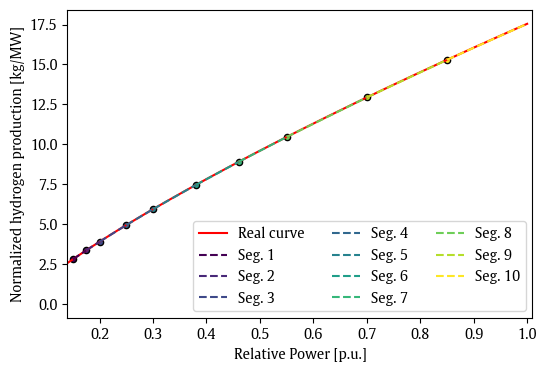

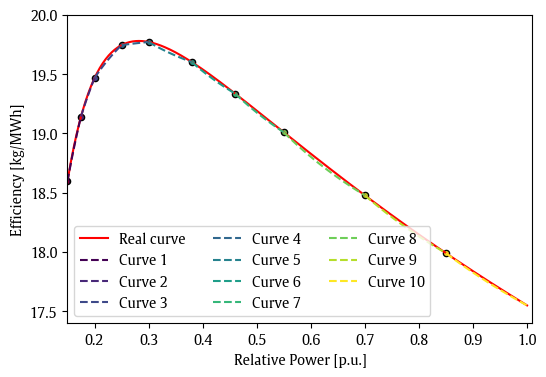

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters (same as before)
a1, a2, a3, a4 = 1.5184, 1.5421E-03, 9.523E-05, 9.84E-08
r1, r2 = 4.45153E-05, 6.88874E-09
d1, d2 = -3.12996E-06, 4.47137E-07
s, t1, t2, t3 = 0.33824, -0.01539, 2.00181, 15.24178
f11, f12, f21, f22 = 478645.74, -2953.15, 1.0396, -0.00104
F_const = 96485.3321
M_H2 = 2.0159
HHV = 39.41
T_cell = 90
p_cell = 30
A_cell = 0.2
C_E = 104.5 / 2
i_max = 5000

# Current density vector (avoid zero to prevent log issues)
i = np.linspace(1, i_max, 500)

# Functions from the model
def U_rev(T):
    T_K = T + 273.15
    return a1 - a2 * T_K + a3 * T_K * np.log(T_K) + a4 * T_K**2

def U_cell(T, p, i):
    return U_rev(T) + ((r1 + d1) + r2 * T + d2 * p) * i + s * np.log10((t1 + t2 / T + t3 / T**2) * i + 1)

def P_cell(T, p, i):
    return i * U_cell(T, p, i)

def eta_F(T, i):
    return (i**2 / (f11 + f12 * T + i**2)) * (f21 + f22 * T)

def H2_production(T, i, A, n_c):
    return (eta_F(T, i) * n_c * M_H2 * i * A) / (2 * F_const) * 3.6  # kg/h

def eta_kg_per_MWh(T, i, A, n_c):
    P_elec = P_cell(T, p_cell, i) * A * n_c / 1e6  # MW
    return H2_production(T, i, A, n_c) / P_elec  # kg/MWh

def n_cell(i_max, A_cell, C_E, T, p):
    I_max_cell = i_max * A_cell
    U_max_cell = U_cell(T, p, i_max)
    P_max_cell = I_max_cell * U_max_cell
    return (C_E * 1e6) / P_max_cell

# Generate the master curve from the cell-level model:
n_c = n_cell(i_max, A_cell, C_E, T_cell, p_cell)
P_elec = P_cell(T_cell, p_cell, i) * A_cell * n_c / 1e6  # MW (master curve)
H2_prod = H2_production(T_cell, i, A_cell, n_c)            # kg/h
efficiency = eta_kg_per_MWh(T_cell, i, A_cell, n_c)         # kg/MWh

# Remove any potential NaNs/infs
efficiency = np.nan_to_num(efficiency, nan=0, posinf=0, neginf=0)

# Create the master (dimensionless) curve for h(x) = x * f(x)
P_max_model = np.max(P_elec)
x_master = P_elec / P_max_model  # normalized power, x in [0, 1]
h_master = x_master * efficiency  # h(x) = x * f(x)

# Plot the master h(x) curve
# plt.figure(figsize=(6, 4))
# plt.plot(x_master, h_master, color='b')
# plt.xlim(0.15, 1.01)
# plt.xlabel("Power / Capacity [p.u.]")
# plt.ylabel("Normalized hydrogen production [kg/MWh]")
# plt.grid()
# plt.show()

# -----------------------------------------------------------------------------
# Approximate h(x) piecewise linearly using linear functions.
# x_breakpoints = [0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x_breakpoints = [0.15, 0.175, 0.2, 0.25, 0.3, 0.38, 0.46, 0.55, 0.7, 0.85, 1.0]
h_breakpoints = np.interp(x_breakpoints, x_master, h_master)
num_segments = len(x_breakpoints) - 1
A_segments = []
B_segments = []
for j in range(num_segments):
    x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
    h0, h1 = h_breakpoints[j], h_breakpoints[j+1]
    A = (h1 - h0) / (x1 - x0)
    B = h0 - A * x0
    A_segments.append(A)
    B_segments.append(B)
    print(f"Segment {j}: Interval [{x0:.4f}, {x1:.4f}], A = {A:.5f}, B = {B:.5f}")

# Plot each piecewise linear segment in a different color.
plt.figure(figsize=(6, 4))
# Define a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_segments))
plt.plot(x_master, h_master, label='Real curve', color='r')  # Original curve in red
for j in range(num_segments):
    # Generate a set of x values for this segment
    x_seg = np.linspace(x_breakpoints[j], x_breakpoints[j+1], 50)
    h_seg = A_segments[j] * x_seg + B_segments[j]
    plt.plot(x_seg, h_seg, label=f'Seg. {j+1}', color=colors[j], linestyle='--')
    plt.scatter(x_breakpoints[j], h_breakpoints[j], color=colors[j], edgecolor='black', s=20)  # Mark segment start points with smaller size
plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Normalized hydrogen production [kg/MW]")
plt.xlim(0.14, 1.01)
plt.legend(ncol=3, loc='lower right')
plt.savefig('Normalized_hydrogen_production_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

# -----------------------------------------------------------------------------
# Given an operating point (P, Pmax), approximate g(P, Pmax) as:
#   1. Compute x = P/Pmax.
#   2. Find the segment.
#   3. h(x) ≈ A_i * x + B_i, and then
#      g(P, Pmax) ≈ Pmax * h(x) = A_i * P + B_i * Pmax.
P_max_actual = P_max_model  # Example: actual Pmax 20% higher than model
P_values = np.linspace(0, P_max_actual, 1000)

def approx_g(P, P_max, x_breakpoints, A_segs, B_segs):
    x = P / P_max
    if x >= 1.0:
        seg = len(x_breakpoints) - 2
    else:
        seg = np.searchsorted(x_breakpoints, x, side='right') - 1
    h_approx = A_segs[seg] * x + B_segs[seg]
    return P_max * h_approx

g_approx = np.array([approx_g(P, P_max_actual, x_breakpoints, A_segments, B_segments)
                     for P in P_values])

# For comparison, compute "exact" g from the master efficiency curve.
efficiency_actual = np.interp(P_values / P_max_actual, x_master, efficiency)
g_exact = P_values * efficiency_actual

# ---------------------------------------------------------------------------
# Plot efficiency f(x) = h(x)/x and its approximation f_j(x) = A_j + B_j/x
f_exact = efficiency  # already computed earlier: f(x) = h(x)/x

plt.figure(figsize=(6, 4))
plt.plot(x_master, f_exact, label='Real curve', color='r')

# Plot each piecewise approximation of f(x)
for j in range(num_segments):
    x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
    x_seg = np.linspace(x0, x1, 100)
    f_seg = A_segments[j] + B_segments[j] / x_seg
    plt.plot(x_seg, f_seg, linestyle='--', label=f'Curve {j+1}', color=colors[j])
    plt.scatter(x0, A_segments[j] + B_segments[j] / x0, color=colors[j], edgecolor='black', s=20)

plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Efficiency [kg/MWh]")
plt.xlim(0.15, 1.01)
plt.ylim(17.4,20)
plt.legend(ncol=3, loc='lower left')
plt.savefig('Efficiency_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()


In [166]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_piecewise_metrics(x_master, h_master, efficiency, x_breakpoints):
    # Reconstruct piecewise linear h(x)
    h_breakpoints = np.interp(x_breakpoints, x_master, h_master)
    A_segments, B_segments = [], []
    num_segments = len(x_breakpoints) - 1
    for j in range(num_segments):
        x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
        h0, h1 = h_breakpoints[j], h_breakpoints[j+1]
        A = (h1 - h0) / (x1 - x0)
        B = h0 - A * x0
        A_segments.append(A)
        B_segments.append(B)

    # ---- Evaluate h(x) ----
    h_approx_master = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        h_approx_master[idx] = A_segments[seg] * x + B_segments[seg]

    valid_idx = (x_master >= 0.15) & (x_master <= 1.0)
    h_true = h_master[valid_idx]
    h_pred = h_approx_master[valid_idx]
    mae_h = mean_absolute_error(h_true, h_pred)
    rmse_h = np.sqrt(mean_squared_error(h_true, h_pred))
    r2_h = r2_score(h_true, h_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_h = np.mean(np.abs((h_true - h_pred) / np.where(h_true != 0, h_true, np.nan))) * 100

    # ---- Evaluate f(x) ----
    f_approx = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x < 0.15:
            f_approx[idx] = 0
        elif x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        f_approx[idx] = A_segments[seg] + B_segments[seg] / x

    f_true = efficiency[valid_idx]
    f_pred = f_approx[valid_idx]
    mae_f = mean_absolute_error(f_true, f_pred)
    rmse_f = np.sqrt(mean_squared_error(f_true, f_pred))
    r2_f = r2_score(f_true, f_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_f = np.mean(np.abs((f_true - f_pred) / np.where(f_true != 0, f_true, np.nan))) * 100

    return {
        "breakpoints": x_breakpoints,
        "segments": num_segments,
        "mae_h": mae_h,
        "mape_h": mape_h,
        "rmse_h": rmse_h,
        "r2_h": r2_h,
        "mae_f": mae_f,
        "mape_f": mape_f,
        "rmse_f": rmse_f,
        "r2_f": r2_f
    }

# Configurations of breakpoints to compare
configs = [
    [0.15, 0.3, 1.0],                        
    [0.15, 0.25, 0.4, 1.0],                  
    [0.15, 0.175, 0.2, 0.25, 0.3, 0.5, 1.0],
    [0.15, 0.175, 0.2, 0.25, 0.3, 0.38, 0.46, 0.55, 0.7, 0.85, 1.0],                        
    [0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.40, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0],          
]

# 2) Evaluate each configuration
results = []
for bp in configs:
    res = evaluate_piecewise_metrics(x_master, h_master, efficiency, bp)
    # record also the number of segments
    res["num_segments"] = len(bp) - 1
    results.append(res)

# 3) Summarize in a DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[[
    "num_segments",
    "mae_h", "mape_h", "rmse_h", "r2_h",
    "mae_f", "mape_f", "rmse_f", "r2_f"
]]
print(df_results)


   num_segments     mae_h    mape_h    rmse_h      r2_h     mae_f    mape_f  \
0             2  0.214709  2.064240  0.253927  0.996419  0.390808  2.064240   
1             3  0.121110  1.077705  0.152408  0.998710  0.202145  1.077705   
2             6  0.067927  0.567791  0.088784  0.999562  0.105951  0.567791   
3            10  0.006992  0.070882  0.008275  0.999996  0.013448  0.070882   
4            12  0.004269  0.048247  0.005008  0.999999  0.009228  0.048247   

     rmse_f      r2_f  
0  0.447758  0.591750  
1  0.239282  0.883410  
2  0.130070  0.965550  
3  0.015516  0.999510  
4  0.011459  0.999733  


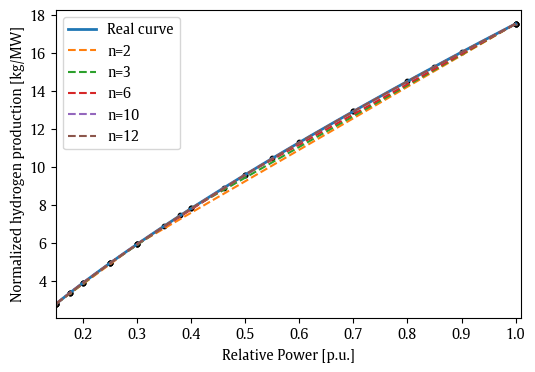

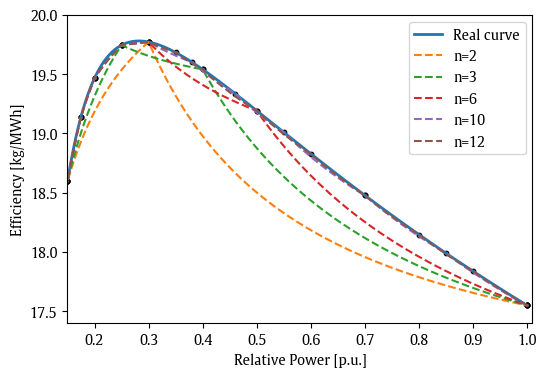

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes x_master, h_master, efficiency are defined from Block 1 ---

# Define valid domain mask
mask = (x_master >= 0.15) & (x_master <= 1.0)
x_plot = x_master[mask]
h_plot = h_master[mask]
f_plot = efficiency[mask]

# Configurations of breakpoints to compare
configs = [
    [0.15, 0.3, 1.0],                        
    [0.15, 0.25, 0.4, 1.0],                  
    [0.15, 0.175, 0.2, 0.25, 0.3, 0.5, 1.0],
    [0.15, 0.175, 0.2, 0.25, 0.3, 0.38, 0.46, 0.55, 0.7, 0.85, 1.0],                        
    [0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.40, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0],          
]

# Plot h(x) approximations only over valid domain
plt.figure(figsize=(6, 4))
plt.plot(x_plot, h_plot, label='Real curve', linewidth=2)
for bp in configs:
    h_bp = np.interp(bp, x_master, h_master)
    A_segs, B_segs = [], []
    for j in range(len(bp)-1):
        x0, x1 = bp[j], bp[j+1]
        h0, h1 = h_bp[j], h_bp[j+1]
        A_segs.append((h1-h0)/(x1-x0))
        B_segs.append(h0 - A_segs[-1]*x0)
    # build approximation over x_plot
    h_approx = np.array([A_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]*x + 
                         B_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]
                        for x in x_plot])
    line, = plt.plot(x_plot, h_approx, '--', label=f'n={len(bp)-1}')
    f_bp = np.interp(bp, x_master, h_master)
    plt.scatter(bp, f_bp, color=line.get_color(), edgecolor='k', s=10)
plt.xlim(0.15, 1.01)
plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Normalized hydrogen production [kg/MW]")
plt.legend(loc='best')
plt.savefig('Normalized_hydrogen_production_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

# Plot f(x) approximations only over valid domain
plt.figure(figsize=(6, 4))
plt.plot(x_plot, f_plot, label='Real curve', linewidth=2)
for bp in configs:
    h_bp = np.interp(bp, x_master, h_master)
    A_segs, B_segs = [], []
    for j in range(len(bp)-1):
        x0, x1 = bp[j], bp[j+1]
        h0, h1 = h_bp[j], h_bp[j+1]
        A_segs.append((h1-h0)/(x1-x0))
        B_segs.append(h0 - A_segs[-1]*x0)
    f_approx = np.array([A_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))] +
                         B_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]/x
                        for x in x_plot])
    # plot approximation and breakpoints
    line, = plt.plot(x_plot, f_approx, '--', label=f'n={len(bp)-1}')
    f_bp = np.interp(bp, x_master, efficiency)
    plt.scatter(bp, f_bp, color=line.get_color(), edgecolor='k', s=10)

plt.xlim(0.15, 1.01)
plt.ylim(17.4,20)
plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Efficiency [kg/MWh]")
plt.legend(loc='best')
plt.savefig('Efficiency_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()


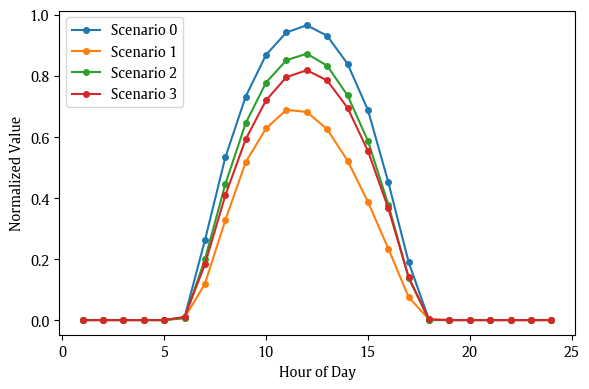

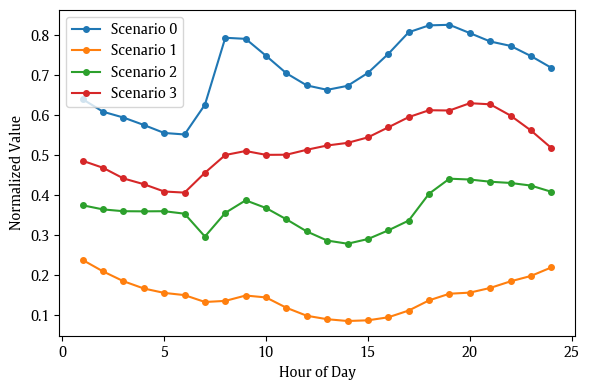

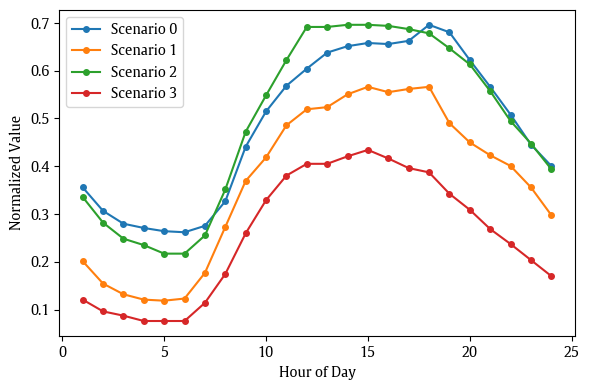

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs again, assuming the index should be 1 to 24 (hours), and columns are the 5 types
df_fPV = pd.read_csv('pv_representative_ninja24.csv', index_col=0).T
df_fWT = pd.read_csv('wind_representative_ninja24.csv', index_col=0).T
df_PD  = pd.read_csv('demand_representative_ninja24.csv', index_col=0).T

# Fix index to represent hour of day (1 to 24)
df_fPV.index = range(1, 25)
df_fWT.index = range(1, 25)
df_PD.index = range(1, 25)

# Plotting function
def plot_profiles(df, title):
    plt.figure(figsize=(6, 4))
    for col in df.columns:
        plt.plot(df.index, df[col], marker='o', label=f'Scenario {col}', markersize=4)  # Reduced marker size
    plt.xlabel("Hour of Day")
    plt.ylabel("Normalized Value")
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.pdf", bbox_inches='tight', pad_inches=0.02)
    plt.show()

# Generate plots
plot_profiles(df_fPV, "PV Generation Profiles")
plot_profiles(df_fWT, "Wind Generation Profiles")
plot_profiles(df_PD, "Demand Profiles")
